# Frequency Projection

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

import data_cleansing as dc
import data_utils as du

## load the data and apply cleaning steps


In [2]:
data_train_raw, data_test_raw = dc.load_file()

data_test = data_test_raw.copy()
data_train = data_train_raw.copy()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Setup the dataset 
Set the target

In [3]:
data_train['freq'] = data_train['ClaimNb']/data_train['Exposure']
data_test['freq'] = data_test['ClaimNb']/data_test['Exposure']

target_name_freq ='freq'
target_name_sev = "severity"


In [4]:
data_train.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,severity,DrivAgeBand,DensityBand,VehAgeBand,freq
IDpol,,,,,,,,,,,,,,,,,
139,1,0.75,F,7,1,61,0.50,B12,Regular,27000,R11,303.00,303.00,"(55,65]","(5e+03,Inf]",1,1.333333
190,1,0.14,B,12,5,50,0.60,B12,Diesel,56,R25,1981.84,1981.84,"(45,55]","(50,100]",5,7.142857
414,1,0.14,E,4,0,36,0.85,B12,Regular,4792,R11,1456.55,1456.55,"(35,45]","(2e+03,5e+03]",0,7.142857
424,2,0.62,F,10,0,51,1.00,B12,Regular,27000,R11,10834.00,5417.00,"(45,55]","(5e+03,Inf]",0,3.225806
606,1,0.84,D,10,6,54,0.50,B12,Diesel,583,R93,1840.14,1840.14,"(45,55]","(400,1e+03]",6,1.190476


## Apply lable encoding to the factors

In [5]:

label_encode_factors = ['Area',
                        'VehPower',
                        'VehBrand',
                        'VehGas',
                        'Region',
                        'DrivAgeBand',
                        'DensityBand',
                        'VehAgeBand'
                       ]
# encode training data and save encoders used
data_train_encoded, encoders = du.preprocess_labelencode(data_train, label_encode_factors)

# apply trained encoders to test set
data_test_encoded = du.preprocess_labelencode_apply(encoders, data_test, label_encode_factors)

data_test_output = data_test_encoded.copy()


# Setup the Frequency projection

## Split target from factors

In [6]:
#sets used to train (resampled sets)
x_train = data_train_encoded[label_encode_factors].copy()
x_train_weights = data_train_encoded['Exposure']
y_train = data_train_encoded[target_name_freq].copy()

#sets used to predict (and evaluate prediction)
x_test = data_test_encoded[label_encode_factors].copy()
y_test = data_test_encoded[target_name_freq].copy()

## Build the model and predict

use exposure as sample weights

In [7]:
%%time
clf_rf = RandomForestRegressor(min_samples_leaf=50, 
                                n_estimators=100,
                                max_depth=5,
                                max_features='auto',
                                criterion='mse',    #mse or mae
                                verbose=True,
                                oob_score=True,
                                n_jobs=3)
#fit values
clf_rf = clf_rf.fit(x_train.values,
                    y_train.values,
                    sample_weight=x_train_weights)    


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   14.4s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   32.0s finished


Wall time: 37.1 s


In [8]:
#predict values
target_name_freq_predicted = target_name_freq + '_predicted'

#data_test_output[target_name_freq_predicted] = clf_rf.predict(x_train.values)    
data_test_output[target_name_freq_predicted] = clf_rf.predict(x_test.values)  

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.5s finished


# Setup the Severity model

In [9]:
#model only on ClaimNb claims

#data_train_resampled = data_train_encoded.loc[data_train_encoded[target_name]>0]      # this excludes zero claims
data_train_resampled_sev = data_train_encoded.loc[data_train_encoded['ClaimNb']>0].copy()  # this includes zero claims
#data_test_resampled_sev = data_test_encoded.loc[data_test_encoded['ClaimNb']>0].copy()     # this includes zero claims

## Split target from factors

In [10]:
#sets used to train (resampled sets)
x_train = data_train_resampled_sev[label_encode_factors].copy()
x_train_weights = data_train_resampled_sev['Exposure']
y_train = data_train_resampled_sev[target_name_sev].copy()

#sets used to predict (and evaluate prediction)
x_test = data_test_encoded[label_encode_factors].copy()
y_test = data_test_encoded[target_name_sev].copy()


## Build the model and predict

In [11]:
%%time
clf_rf = RandomForestRegressor(min_samples_leaf=30, 
                                n_estimators=200,
                                max_depth=10,
                                max_features='auto',
                                criterion='mse',    #mse or mae
                                verbose=True,
                                oob_score=True,
                                n_jobs=3)
#fit values
clf_rf = clf_rf.fit(x_train.values, 
                    y_train.values,
                    sample_weight=x_train_weights)    



[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    2.2s finished


Wall time: 3.3 s


In [12]:
target_name_sev_predicted = target_name_sev + '_predicted'

#data_train_resampled_sev[target_name_sev_predicted] = clf_rf.predict(x_train.values)    
data_test_output[target_name_sev_predicted] = clf_rf.predict(x_test.values)   

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    1.6s finished


## Combine Freq and Sev Results

In [13]:
data_test_output['predicted_total'] = data_test_output[target_name_freq_predicted]*data_test_output['Exposure']*data_test_output[target_name_sev_predicted]

data_test_output.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,severity,DrivAgeBand,DensityBand,VehAgeBand,freq,freq_predicted,severity_predicted,predicted_total
IDpol,,,,,,,,,,,,,,,,,,,,
463,1,0.31,0,1,0,45,0.50,3,1,12,15,3986.67,3986.67,2,0,0,3.225806,0.055585,1521.723571,26.221195
811,1,0.76,4,1,0,44,0.50,3,1,3317,20,971.98,971.98,2,4,0,1.315789,0.086026,1941.424688,126.929153
830,1,0.68,4,0,10,24,1.05,0,1,3064,0,1442.75,1442.75,0,4,2,1.470588,0.147585,2591.430479,260.070681
975,1,0.73,3,5,0,60,0.50,3,1,570,20,637.41,637.41,4,5,0,1.369863,0.080244,2085.228387,122.149309
1323,1,0.62,4,4,4,67,0.72,3,1,2674,20,384.77,384.77,5,4,11,1.612903,0.082392,4325.476620,220.958623


# Test the results 

In [24]:

def evaluation_metrics(actual, predicted, rowname="Evaluation Metrics"):

    metrics = {
        # total claim results
        'sum actual' : np.sum(actual),
        'sum predict': np.sum(predicted),
        'sum ratio': np.sum(predicted)/np.sum(actual),
        # results metrics
        'gini' : du.gini(actual, predicted),
        'mse'  : mean_squared_error(actual, predicted, squared=True),
        'rmse' : mean_squared_error(actual, predicted, squared=False),
        'mae'  :mean_absolute_error(actual, predicted),
        'r2'   : r2_score(actual, predicted),
    }
    
    metrics_df = pd.DataFrame(metrics, index=[rowname])
    return metrics_df

out_f_predicted = 'freq_predicted'
out_f_original = 'freq'

out_c_predicted = 'predicted_total'
out_c_original = 'ClaimAmount'

e_metrics_frequency = evaluation_metrics(data_test_output[out_f_original],  data_test_output[out_f_predicted], rowname='frequency model')
e_metrics_ClaimAmount = evaluation_metrics(data_test_output[out_c_original],  data_test_output[out_c_predicted], rowname='ClaimAmount')
metrics = pd.concat([e_metrics_frequency,e_metrics_ClaimAmount])
metrics

,sum actual,sum predict,sum ratio,gini,mse,rmse,mae,r2
frequency model,1.442796e+04,1.255572e+04,0.870236,0.081973,3.246587e-01,0.569788,0.155378,0.002280
ClaimAmount,1.478716e+07,1.400784e+07,0.947298,0.037150,3.982292e+06,1995.568085,164.593674,-0.000918


### Output the results

In [25]:
data_test_output.to_csv('FS Test Predictions Output.csv')
metrics.to_csv('Metrics Summary.csv')


# Review the Results in Charts

## Plot of distribution of results

In [17]:
#%% plot distribution charts
#x_train_to_predict[[target_name, target_name_predicted]].plot(kind='kde', figsize=(20,10))
#x_test[[target_name, target_name_predicted]].plot(kind='kde', figsize=(20,10))


In [18]:
data_test_output.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,severity,DrivAgeBand,DensityBand,VehAgeBand,freq,freq_predicted,severity_predicted,predicted_total
IDpol,,,,,,,,,,,,,,,,,,,,
463,1,0.31,0,1,0,45,0.50,3,1,12,15,3986.67,3986.67,2,0,0,3.225806,0.055585,1521.723571,26.221195
811,1,0.76,4,1,0,44,0.50,3,1,3317,20,971.98,971.98,2,4,0,1.315789,0.086026,1941.424688,126.929153
830,1,0.68,4,0,10,24,1.05,0,1,3064,0,1442.75,1442.75,0,4,2,1.470588,0.147585,2591.430479,260.070681
975,1,0.73,3,5,0,60,0.50,3,1,570,20,637.41,637.41,4,5,0,1.369863,0.080244,2085.228387,122.149309
1323,1,0.62,4,4,4,67,0.72,3,1,2674,20,384.77,384.77,5,4,11,1.612903,0.082392,4325.476620,220.958623


## Plot of mean claim numbers split by factor level

### Plot fit of data

Area
VehPower
VehBrand
VehGas
Region
DrivAgeBand
DensityBand
VehAgeBand
predicted_total
--target
ClaimAmount
--target


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


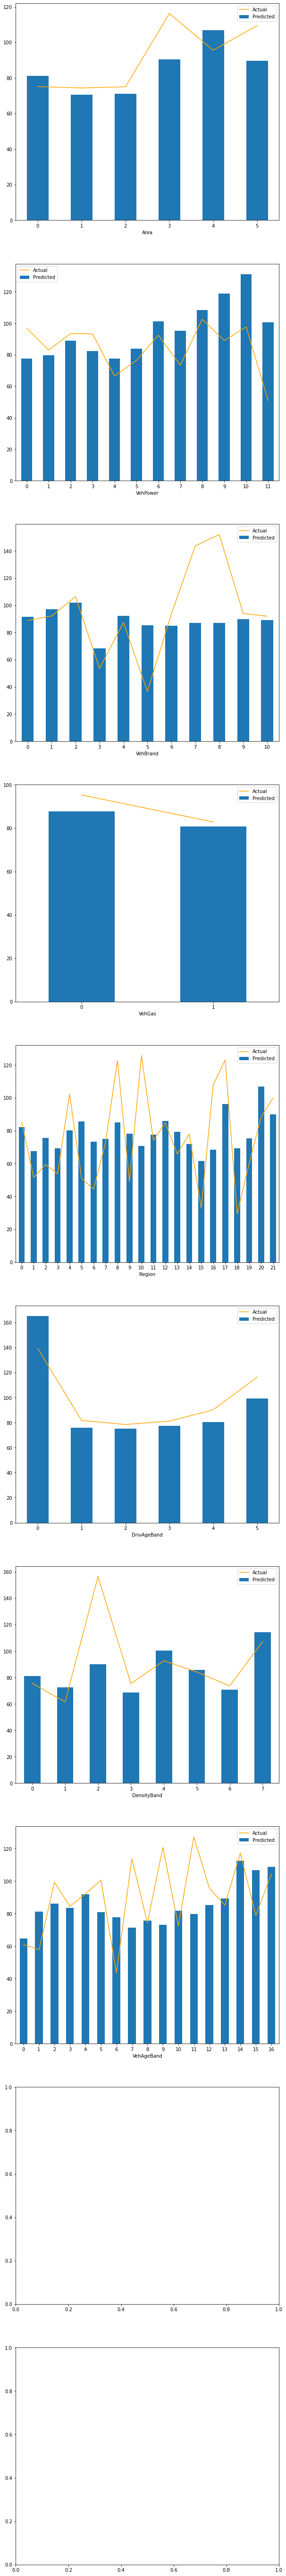

In [19]:
label_encode_factors = ['Area',
                        'VehPower',
                        'VehBrand',
                        'VehGas',
                        'Region',
                        'DrivAgeBand',
                        'DensityBand',
                        'VehAgeBand'
                       ]

label_encode_factors.extend([out_predicted,out_original])

fig = du.plot_factors(data_test_output[label_encode_factors], out_original, out_predicted)
fig.show()